## A Bayesian autoencoder

### How the autoencoder works

The autoencoder attempts to approximate the posterior distribution
$$p(z | x) \propto p(x | z) p(z)$$
Where $x$ is a vector representing the pixels of an image, and $z$ is a latent variable (i.e. it has its own probability distribution) that represents an encoding. Given a prior $p(z)$ for the encoding distribution, we want to be able to define the distribution of the encoding for a given image $p(z | x)$.

As a prior for $z$, we assume that the elements of the $z$ vector (assumed by default in the `VariationalAE` below to have 50 dimensions) are standard normal-distributed. Given a draw from the $z$ distribution, each element of $x$ (representing a single pixel) is drawn from a Bernoulli distribution with probability parameter determined by the interaction between $z$ and the weights of the `Decoder` neural network. That is, the conditional distribution $p(x | z)$ implicitly has the weights of the `Decoder` network as fixed parameters. The weights of the `Decoder` network are themselves set by what amounts to maximum likelihood estimation (the `Decoder` neural network is not fully Bayesian).

Because the $z$ distribution has many dimensions, it is difficult to fully explore the posterior using a method like MCMC, so we use variational inference instead. The idea is to use a variational distribution $q(z)$ (defined by the `guide` method of the `VariationalAE` class) to approximate $p(z | x)$. Here the variational distribution is a multivariate normal distribution over the $z$ vector, similar to the prior for $z$, but with the difference that the means and variances of each element of $z$ are determined as outputs from the `Encoder` neural network. The idea behind the variational inference is to set the parameters of the `Encoder` neural network so as to minimize the KL divergence between the variational distribution $q(z)$ and the posterior $p(z | x)$ -- in reality the optimizer code actually works to maximize the "evidence lower bound" (a.k.a. ELBO) defined as $\text{E}_{q}[\log p(x, z) - \log q(z)]$, although this is equivalent to minimizing the KL divergence between $q(z)$ and $q(z|x)$. To fit the model, we essentially carry out stochastic gradient ascent over the parameters of the variational distribution (the `Encoder`). 


#### What is this good for?

An autoencoder is used learn a lower-dimensional representation for data. Here, the input images from the MNIST data set have $28 \times 28 = 784$ dimensions, while the default encoding dimension is 50. Autoencoders are used to extract the important features of a data set and are used for things like face recognition and natural language processing. Because the encoding space in this model is treated as a random vector (in contrast to a traditional, non-Bayesian, autoencoder where the encodings are fixed given the input data), this autoencoder allows us to get a sense of the uncertainty in the encodings: if, after fitting the model, we encode and then decode a given image, we'll get an image similar to the original, and if we do it again, we'll get a slightly different image -- this is because we're effectively drawing decoded images based on the posterior distribution of the encodings. Example input and output images are shown below. Ideally, if we have enough training data and the encoder we use is sufficently versatile, the variance of the encodings should be very low.

In [1]:
import torch
from torch import nn

import pyro
import pyro.distributions as dist

from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from seaborn import kdeplot

In [2]:
# Create loaders for train and test data sets
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=64)

IMAGE_DIM = 28

In [3]:
# start by defining the decoder and encoder neural networks

class Decoder(nn.Module):
    """Takes an encoding and outputs a [flat] image vector
    """
    def __init__(self, enc_dim, hidden_dim):
        super().__init__()
        # set up linear transformations
        self.lin1 = nn.Linear(enc_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, IMAGE_DIM**2)
        # set up nonlinearities
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, enc):
        hidden = self.relu(self.lin1(enc))
        return self.sigmoid(self.lin2(hidden))
    
    
class Encoder(nn.Module):
    """Takes a [flat] image vector and returns loc and scale for encoding
    """
    def __init__(self, enc_dim, hidden_dim):
        super().__init__()
        # set up linear transformations
        self.lin1 = nn.Linear(IMAGE_DIM**2, hidden_dim)
        self.lin2a = nn.Linear(hidden_dim, enc_dim)  # for loc
        self.lin2b = nn.Linear(hidden_dim, enc_dim)  # for scale
        # set up nonlinearity
        self.relu = nn.ReLU()
    
    def forward(self, images):
        # flatten images
        images = images.view(-1, IMAGE_DIM**2)
        # transform
        hidden = self.relu(self.lin1(images))
        enc_loc = self.lin2a(hidden)
        enc_scale = torch.exp(self.lin2b(hidden))
        return enc_loc, enc_scale
    
# now define the variational Bayesian autoencoder model
class VariationalAE(nn.Module):
    """Variational auto-encoder using above defined Decoder and Encoder
    """
    def __init__(self, enc_dim=50, hidden_dim=400):
        super().__init__()
        # create encoder and decoder instances
        self.encoder = Encoder(enc_dim, hidden_dim)
        self.decoder = Decoder(enc_dim, hidden_dim)
        # save encoding dimension
        self.enc_dim = enc_dim
        # create spot for svi object (for model fit and evaluation)
        self.svi = None
    
    def model(self, images):
        """Represents the model p(x|z) p(z), x is the observed image, z is the encoding
        The p(x|z) is based on the Decoder neural net with z as inputs
        """
        # register decoder module with Pyro
        pyro.module('decoder', self.decoder)
        with pyro.plate('data', images.shape[0]):
            # set parameters for p(z) prior
            # prior will be multivariate standard normal
            enc_loc = torch.zeros(images.shape[0], self.enc_dim)
            enc_scale = torch.ones(images.shape[0], self.enc_dim)
            # sample from prior distribution p(z)
            enc = pyro.sample('enc', dist.Normal(enc_loc, enc_scale).to_event(1))
            # decode the sampled encoding
            decoded_images = self.decoder.forward(enc)
            # observe actual images
            pyro.sample('obs', dist.Bernoulli(decoded_images).to_event(1),
                        obs=images.view(-1, IMAGE_DIM**2))
    
    def guide(self, images):
        """Represents the variational distribution q(z)
        The q(z) is essentially the Encoder neural net with given x as inputs,
        i.e. z is modeled as conditional on x, so it may be more clear to write it as q(z | x)
        """
        # register encoder module with Pyro
        pyro.module('encoder', self.encoder)
        with pyro.plate('data', images.shape[0]):
            # get loc and scale params for q(z|x) via encoder
            enc_loc, enc_scale = self.encoder.forward(images)
            # sample from q(z|x)
            pyro.sample('enc', dist.Normal(enc_loc, enc_scale).to_event(1))
    
    def fit(self, train_loader, n_epochs=1, lr=0.001):
        """Fit the variational distribution to the posterior distribution
        Uses Adam gradient descent to maximize ELBO (minimize -ELBO)
        """
        if self.svi is None:
            optimizer = pyro.optim.Adam({'lr': lr})
            elbo = pyro.infer.Trace_ELBO()
            self.svi = pyro.infer.SVI(self.model, self.guide, optimizer, loss=elbo)
        train_size = len(train_loader.dataset)
        losses = []
        for i in range(n_epochs):
            loss = 0
            for images, _ in train_loader:
                loss += self.svi.step(images)
            losses.append(loss)
            print(f'Epoch {i+1}: loss = {loss / train_size}')
        return losses
    
    def evaluate(self, test_loader):
        """Calculates loss for the test set
        """
        assert self.svi is not None, 'Model must be fit first'
        loss = 0
        test_size = len(test_loader.dataset)
        for images, _ in test_loader:
            loss += self.svi.evaluate_loss(images)
        print(f'loss on test set is {loss / test_size}')
        return loss
    
    def reconstruct(self, images):
        """encodes images then decodes
        if the model fit is good, the output should look similar to the input
        """
        with torch.no_grad():
            enc_loc, enc_scale = self.encoder.forward(images)
            enc = dist.Normal(enc_loc, enc_scale).sample()
            decoded_images = self.decoder.forward(enc)
        return decoded_images

In [4]:
N_EPOCHS = 15
pyro.clear_param_store()

vae = VariationalAE()
train_losses = vae.fit(train_loader, n_epochs=N_EPOCHS)
test_loss = vae.evaluate(test_loader)

Epoch 1: loss = 157.78597112019858
Epoch 2: loss = 121.63886541748047
Epoch 3: loss = 113.98487134602864
Epoch 4: loss = 110.93584629720053
Epoch 5: loss = 109.2832642171224
Epoch 6: loss = 108.22656422729492
Epoch 7: loss = 107.52348530883789
Epoch 8: loss = 106.95885044962566
Epoch 9: loss = 106.53822270711262
Epoch 10: loss = 106.22039475911458
Epoch 11: loss = 105.87152565511067
Epoch 12: loss = 105.63494508666992
Epoch 13: loss = 105.38620018513997
Epoch 14: loss = 105.1906014485677
Epoch 15: loss = 105.00403135986328
loss on test set is 104.51771017456055


### Exploring the posterior distribution

Below I've shown what happens if we encode and then decode images using the fitted model. I've plotted multiple outputs for each input; you can see that each output is slightly different.

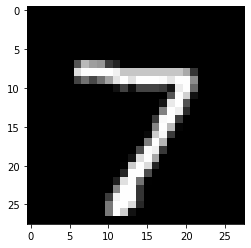

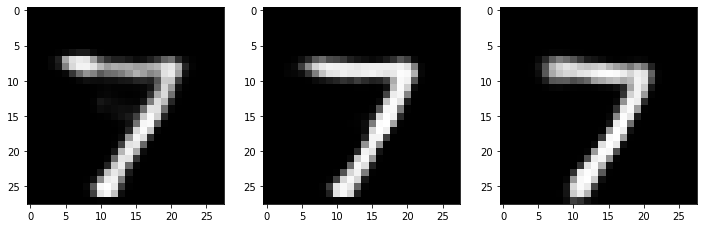

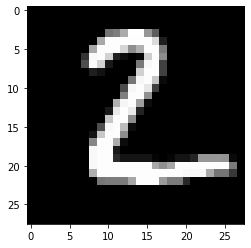

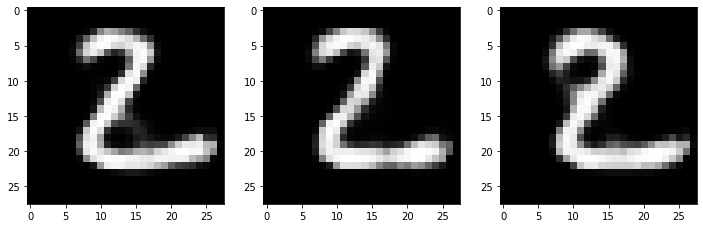

In [5]:
# Reconstruct an image to see how good the encoding is
images, _ = next(iter(test_loader))

# Look at the first two images in the test set
for i in range(2):
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.show()
    # run the reconstruct multiple times to show the stochastic nature of the encoder
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for j in range(3):
        reconstructed_image = vae.reconstruct(images[i]).view(-1, IMAGE_DIM, IMAGE_DIM)
        axs[j].imshow(reconstructed_image.squeeze(), cmap='gray')
    plt.show()

Here I make a large number of draws from the posterior distribution for an encoded and decoded draw from the testing set. I can then compute the average and standard deviation for each pixel, which gives an idea of the typical output and the network's uncertainty at each point. You can see that the mean prediction is the highest near the core of the numeral, while the uncertainty (standard deviation) is high on the edge of the numeral:

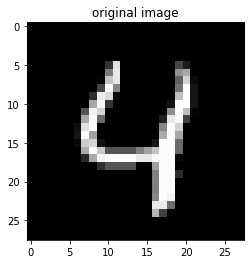

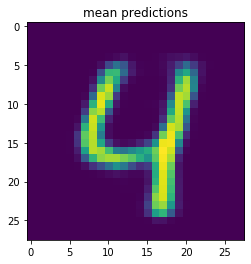

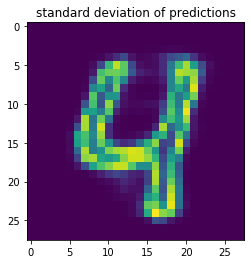

In [6]:
# Do this with the fifth image from the test set
# The third one is boring; it's just a 1
plt.imshow(images[4].squeeze(), cmap='gray')
plt.title('original image')
plt.show()

imgs = vae.reconstruct(torch.stack([images[4] for _ in range(100)])).view(-1, IMAGE_DIM, IMAGE_DIM)
# Plot the mean predictions
plt.imshow(imgs.mean(axis=0).view(IMAGE_DIM, IMAGE_DIM))
plt.title('mean predictions')
plt.show()
# Plot the standard deviation of predictions
plt.imshow(imgs.std(axis=0).view(IMAGE_DIM, IMAGE_DIM))
plt.title('standard deviation of predictions')
plt.show()

We can also look directly at the distribution of the encoding random vector. Below I show posterior distributions for the first five dimensions of the encoding space. In a deterministic autoencoder, these would not have distributions -- they would be fixed maximum likelihood estimates.

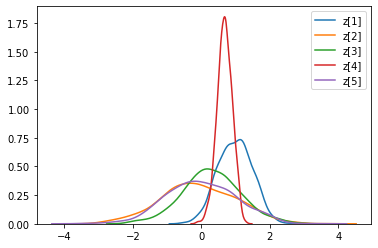

In [7]:
# Show the distribution of the encodings for example input

# Draw from the posterior distribution with the first test image as input
predict_enc = pyro.infer.Predictive(vae.model, guide=vae.guide, num_samples=1000,
                                    return_sites=('enc',))
with torch.no_grad():
    encodings = predict_enc(images[0])['enc']

# Create kernel density plots for the first 5 encoding dimensions
for i in range(5):
    kdeplot(np.array(encodings[:,0,i]), label=f'z[{i+1}]')
    plt.legend()
plt.show()